In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy import spatial

from src.data import load_point_cloud
from src.plotting import show_point_cloud, draw_unit_cube
from src.orientation import orient_normals
from src.metrics import weight, rms_angle_error

# Ground truth data

In [2]:
xyz, n = load_point_cloud('netsuke')

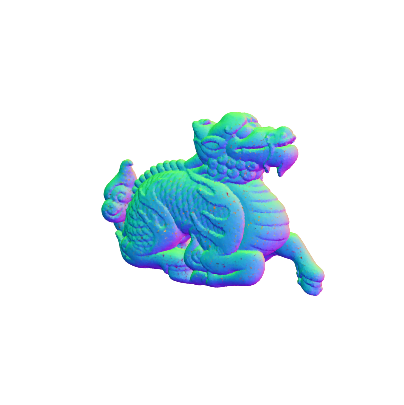

In [3]:
_, ax = show_point_cloud(xyz, n, elev=20, azim=-20);

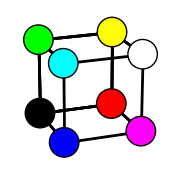

In [4]:
draw_unit_cube(elev=ax.elev, azim=ax.azim);

# Normal estimation

## 1. PCA

In [5]:
def estimate_normals_pca(xyz, k, kernel=None, **kwargs):
    """Return the unit normals by fitting local tangent plane at each
    point in the point cloud.
    
    Ref: Hoppe et al., in proceedings of SIGGRAPH 1992, pp. 71-78,
         doi: 10.1145/133994.134011
    
    Parameters
    ----------
    xyz : numpy.ndarray
        The point cloud of shape (N, 3), N is the number of points.
    k : float
        The number of nearest neighbors of a local neighborhood around
        a current query point.
    kernel : string, optional
        Kernel for computing distance-based weights.
    kwargs : dict, optional
        Additional keyword arguments for computing weights. For details
        see `weight` function.
    
    Returns
    -------
    numpy.ndarray
        The unit normals of shape (N, 3), where N is the number of
        points in the point cloud.
    """
    # create a kd-tree for quick nearest-neighbor lookup
    tree = spatial.KDTree(xyz)
    n = np.empty_like(xyz)
    for i, p in enumerate(xyz):
        # extract the local neighborhood
        _, idx = tree.query([p], k=k, eps=0.1, workers=-1)
        nbhd = xyz[idx.flatten()]
        
        # compute the kernel function and create the weights matrix
        if kernel:
            w = weight(p, nbhd, kernel, **kwargs)
        else:
            w = np.ones((nbhd.shape[0], ))
        W = np.diag(w)
        
        # extract an eigenvector with smallest associeted eigenvalue
        X = nbhd.copy()
        X = X - X.mean(axis=0)
        C = (X.T @ (W @ X)) / (nbhd.shape[0] - 1)
        U, S, VT = np.linalg.svd(C)
        n[i, :] =  U[:, np.argmin(S)]
    return n

In [6]:
n_pca = estimate_normals_pca(xyz, k=30)
n_pca = orient_normals(xyz, n_pca, k=30)

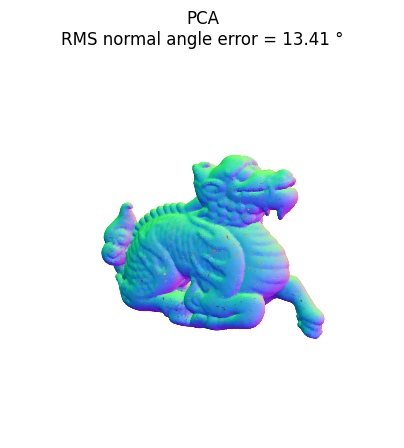

In [7]:
theta_pca = rms_angle_error(n_pca, n)
_, ax_pca = show_point_cloud(xyz, n_pca, elev=ax.elev, azim=ax.azim)
ax_pca.set_title(f'PCA\nRMS normal angle error = {theta_pca:.2f} °');

## Implicit B-Spline

In [8]:
def estimate_normals_spline(xyz,
                            k,
                            deg=3,
                            s=None,
                            unit=True,
                            kernel=None, 
                            **kwargs):
    """Return the (unit) normals by constructing smooth bivariate
    B-spline at each point in the point cloud considering its local
    neighborhood.
    
    Parameters
    ----------
    xyz : numpy.ndarray
        The point cloud of shape (N, 3), N is the number of points.
    k : float
        The number of nearest neighbors of a local neighborhood around
        a current query point.
    deg : float, optional
        Degrees of the bivariate spline.
    s : float, optional
        Positive smoothing factor defined for smooth bivariate spline
        approximation.
    unit : float, optional
        If true, normals are normalized. Otherwise, surface normals are
        returned.
    kernel : string, optional
        Kernel for computing distance-based weights.
    kwargs : dict, optional
        Additional keyword arguments for computing weights. For details
        see `weight` function.
    
    Returns
    -------
    numpy.ndarray
        The (unit) normals of shape (N, 3), where N is the number of
        points in the point cloud.
    """
    # create a kd-tree for quick nearest-neighbor lookup
    tree = spatial.KDTree(xyz)
    n = np.empty_like(xyz)
    for i, p in enumerate(xyz):
        _, idx = tree.query([p], k=k, eps=0.1, workers=-1)
        nbhd = xyz[idx.flatten()]
        
        # change the basis of the local neighborhood
        X = nbhd.copy()
        X = X - X.mean(axis=0)
        C = (X.T @ X) / (nbhd.shape[0] - 1)
        U, _, _ = np.linalg.svd(C)
        Xt = X @ U
        
        # compute weights given specific distance function
        if kernel:
            w = weight(p, nbhd, kernel, **kwargs)
        else:
            w = np.ones((nbhd.shape[0], ))
            
        # create a smooth B-Spline representation of the "height" function
        h = interpolate.SmoothBivariateSpline(*Xt.T, w=w, kx=deg, ky=deg, s=s)
        
        # compute normals as partial derivatives of the "height" function
        ni = np.array([-h(*Xt[0, :2], dx=1).item(),
                       -h(*Xt[0, :2], dy=1).item(),
                       1])
        
        # convert normal coordinates into the original coordinate frame
        ni = U @ ni
        
        # normalize normals by considering the magnitude of each
        if unit:
            ni = ni / np.linalg.norm(ni, 2)
        n[i, :] = ni
    return n

In [11]:
n_spline = estimate_normals_spline(xyz, k=30, unit=True, kernel='rbf')
n_spline = orient_normals(xyz, n_spline, k=30)

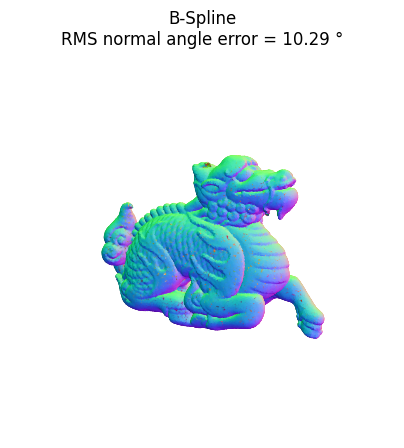

In [12]:
theta_spline = rms_angle_error(n_spline, n)
_, ax_spline = show_point_cloud(xyz, n_spline, elev=ax.elev, azim=ax.azim)
ax_spline.set_title(f'B-Spline\nRMS normal angle error = {theta_spline:.2f} °');

## 2D Polyfit

In [14]:
def estimate_normals_poly(xyz,
                          k,
                          deg=1,
                          unit=True,
                          kernel=None,
                          **kwargs):
    """Return the (unit) normals by fitting 2-D polynomial at each
    point in the point cloud considering its local neighborhood.
    
    Parameters
    ----------
    xyz : numpy.ndarray
        The point cloud of shape (N, 3), N is the number of points.
    k : float
        The number of nearest neighbors of a local neighborhood around
        a current query point.
    deg : float, optional
        Degrees of the polynomial.
    unit : float, optional
        If true, normals are normalized. Otherwise, surface normals are
        returned.
    kernel : string, optional
        Kernel for computing distance-based weights.
    kwargs : dict, optional
        Additional keyword arguments for computing weights. For details
        see `weight` function.
    
    Returns
    -------
    numpy.ndarray
        The (unit) normals of shape (N, 3), where N is the number of
        points in the point cloud.
    """
    from src.utils import polyfit2d
    # create a kd-tree for quick nearest-neighbor lookup
    n = np.empty_like(xyz)
    tree = spatial.KDTree(xyz)
    for i, p in enumerate(xyz):
        _, idx = tree.query([p], k=k, eps=0.1, workers=-1)
        nbhd = xyz[idx.flatten()]
        
        # change the basis of the local neighborhood
        X = nbhd.copy()
        X = X - X.mean(axis=0)
        C = (X.T @ X) / (nbhd.shape[0] - 1)
        U, _, _ = np.linalg.svd(C)
        X_t = X @ U
        
        # compute weights given specific distance function
        if kernel:
            w = weight(p, nbhd, kernel, **kwargs)
        else:
            w = np.ones((nbhd.shape[0], ))
            
        # fit parametric surface by usign a (weighted) 2-D polynomial
        X_t_w = X_t * w[:, np.newaxis]
        c = polyfit2d(*X_t_w.T, deg=deg)
        
        # compute normals as partial derivatives of the "height" function
        cu = np.polynomial.polynomial.polyder(c, axis=0)
        cv = np.polynomial.polynomial.polyder(c, axis=1)
        ni = np.array([-np.polynomial.polynomial.polyval2d(*X_t_w[0, :2], cu),
                       -np.polynomial.polynomial.polyval2d(*X_t_w[0, :2], cv),
                       1])
        
        # convert normal coordinates into the original coordinate frame
        ni = U @ ni
        
        # normalize normals by considering the magnitude of each
        if unit:
            ni = ni / np.linalg.norm(ni, 2)
        n[i, :] = ni
    return n

In [20]:
n_poly = estimate_normals_poly(xyz, k=30, deg=3)
n_poly = orient_normals(xyz, n_poly, k=30)

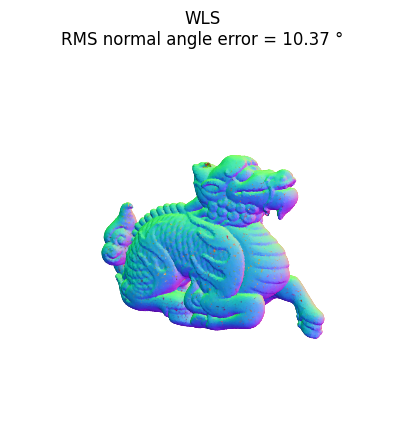

In [21]:
theta_poly = rms_angle_error(n_poly, n)
_, ax_poly = show_point_cloud(xyz, n_poly, elev=ax.elev, azim=ax.azim)
ax_poly.set_title(f'WLS\nRMS normal angle error = {theta_poly:.2f} °');